## env : Kaggle Notebook
## ref : https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

In [1]:
# wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)


In [2]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tokenization
from wordcloud import STOPWORDS

import sklearn
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

print(f'>>> original - np : 1.17.4  |  pd : 0.25.3  |  mpl : 3.0.3  |  sklearn : 0.21.3  |  tf : 2.1.0-rc0  |  hub : 0.7.0  |  keras : 2.2.4-tf')
print(f'>>> present  - np : {np.__version__}  |  pd : {pd.__version__}  |  mpl : {mpl.__version__}  |  sklearn : {sklearn.__version__}  |  tf : {tf.__version__}  |  hub : {hub.__version__}  |  keras : {keras.__version__}')

>>> original - np : 1.17.4  |  pd : 0.25.3  |  mpl : 3.0.3  |  sklearn : 0.21.3  |  tf : 2.1.0-rc0  |  hub : 0.7.0  |  keras : 2.2.4-tf
>>> present  - np : 1.17.4  |  pd : 0.25.3  |  mpl : 3.0.3  |  sklearn : 0.21.3  |  tf : 2.1.0-rc0  |  hub : 0.7.0  |  keras : 2.2.4-tf


In [3]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('../input/nlp-getting-started/test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


## **1. Keyword and Location**

### **1.1 Missing Values**
Both training and test set have same ratio of missing values in `keyword` and `location`.
* **0.8%** of `keyword` is missing in both training and test set
* **33%** of `location` is missing in both training and test set

Since missing value ratios between training and test set are too close, **they are most probably taken from the same sample**. Missing values in those features are filled with `no_keyword` and `no_location` respectively.

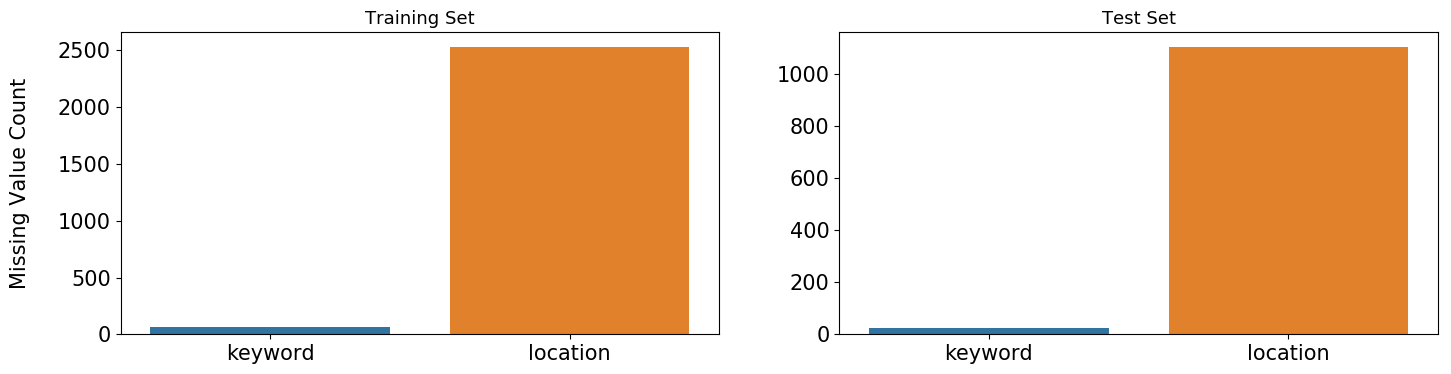

>>> Missing Value Change (train, test) : (2594, 1131) -> (0, 0)


In [4]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(1, 2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[['keyword', 'location']].isna().sum().index, y=df_train[['keyword', 'location']].isna().sum(), ax=axes[0])
sns.barplot(x=df_test[['keyword', 'location']].isna().sum().index,  y=df_test[['keyword', 'location']].isna().sum(),  ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='both', labelsize=15)
axes[0].set_title('Training Set', size=13)
axes[1].tick_params(axis='both', labelsize=15)
axes[1].set_title('Test Set', size=13)

plt.show()

print(f'>>> Missing Value Change (train, test) : ({df_train[missing_cols].isna().sum().sum()}, {df_test[missing_cols].isna().sum().sum()})', end=' -> ')
for df in [df_train, df_test]:
    for col in missing_cols:
        df[col] = df[col].fillna(f'no_{col}')
print(f'({df_train[missing_cols].isna().sum().sum()}, {df_test[missing_cols].isna().sum().sum()})')

### **1.2 Cardinality and Target Distribution**
Locations are not automatically generated, they are user inputs. That's why `location` is very dirty and there are too many unique values in it. It shouldn't be used as a feature.

Fortunately, there is signal in `keyword` because some of those words can only be used in one context. Keywords have very different tweet counts and target means. `keyword` can be used as a feature by itself or as a word added to the text. Every single keyword in training set exists in test set. If training and test set are from the same sample, it is also possible to use target encoding on `keyword`.

In [5]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


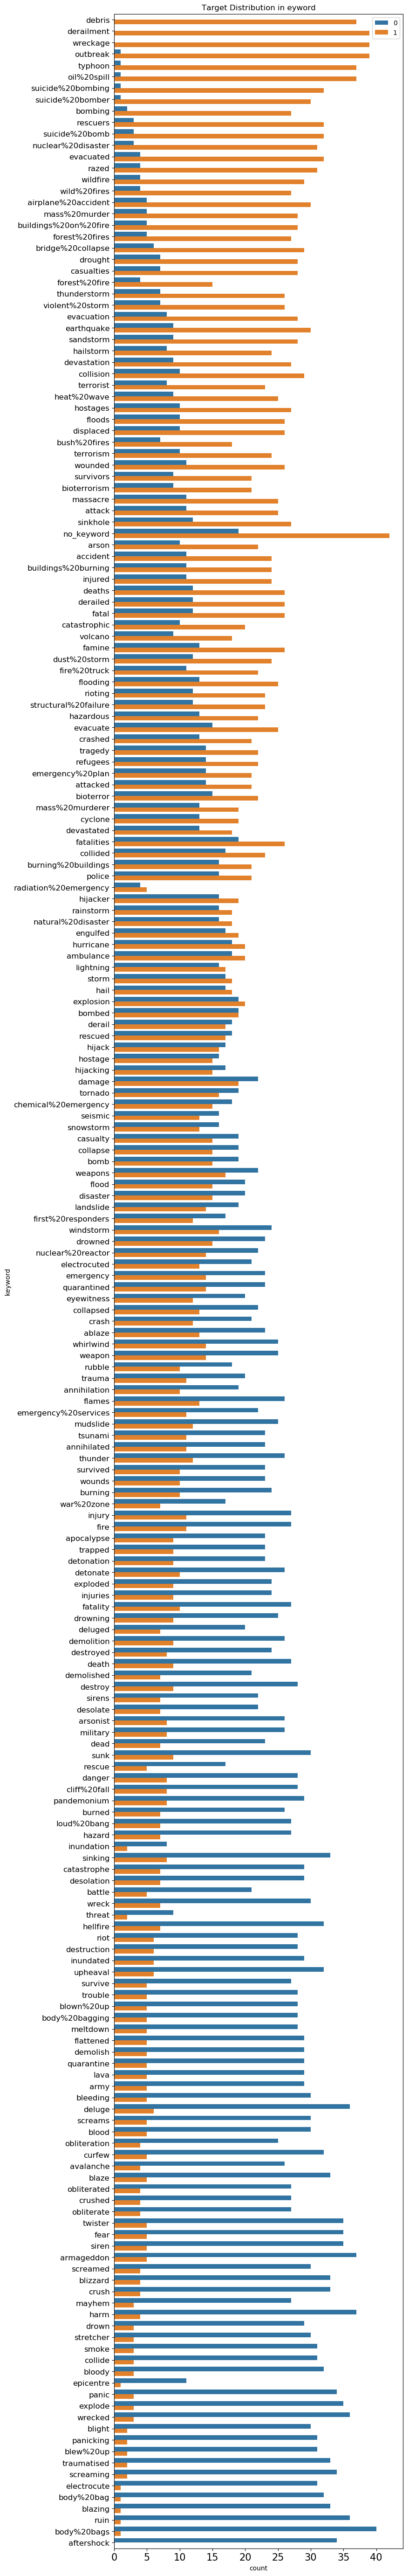

In [6]:
df_train['target_mean'] = df_train.groupby(['keyword'])['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)
sns.countplot(y='keyword', hue='target', data=df_train.sort_values('target_mean', ascending=False))

plt.tick_params('x', labelsize=15)
plt.tick_params('y', labelsize=12)
plt.title('Target Distribution in eyword')
plt.legend(loc='upper right')
plt.show()

df_train = df_train.drop(columns='target_mean')

## **2. Meta Features**
Distributions of meta features in classes and datasets can be helpful to identify disaster tweets. It looks like disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies. Non-disaster tweets have more typos than disaster tweets because they are coming from individual users. The meta features used for the analysis are;
* `word_count` number of words in text
* `unique_word_count` number of unique words in text
* `stop_word_count` number of stop words in text
* `url_count` number of urls in text
* `mean_word_length` average character count in words
* `char_count` number of characters in text
* `punctuation_count` number of punctuations in text
* `hashtag_count` number of hashtags (**#**) in text
* `mention_count` number of mentions (**@**) in text

In [7]:
# # word_count
# df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
# df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# # unique_word_count
# df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
# df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# # stop_word_count
# df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
# df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# # url_count
# df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
# df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# # mean_word_length
# df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
# df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# # char_count
# df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
# df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# # punctuation_count
# df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
# df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# # hashtag_count
# df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
# df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# # mention_count
# df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
# df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

All of the meta features have very similar distributions in training and test set which also proves that training and test set are taken from the same sample.

All of the meta features have information about target as well, but some of them are not good enough such as `url_count`, `hashtag_count` and `mention_count`.

On the other hand, `word_count`, `unique_word_count`, `stop_word_count`, `mean_word_length`, `char_count`, `punctuation_count` have very different distributions for disaster and non-disaster tweets. Those features might be useful in models.

In [8]:
# METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
#                 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
# DISASTER_TWEETS = df_train['target'] == 1

# fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

# for i, feature in enumerate(METAFEATURES):
#     sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
#     sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

#     sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
#     sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
#     for j in range(2):
#         axes[i][j].set_xlabel('')
#         axes[i][j].tick_params(axis='x', labelsize=12)
#         axes[i][j].tick_params(axis='y', labelsize=12)
#         axes[i][j].legend()
    
#     axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
#     axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

# plt.show()

## **3. Target and N-grams**

### **3.1 Target**
Class distributions are **57%** for **0** (Not Disaster) and **43%** for **1** (Disaster). Classes are almost equally separated so they don't require any stratification by `target` in cross-validation.

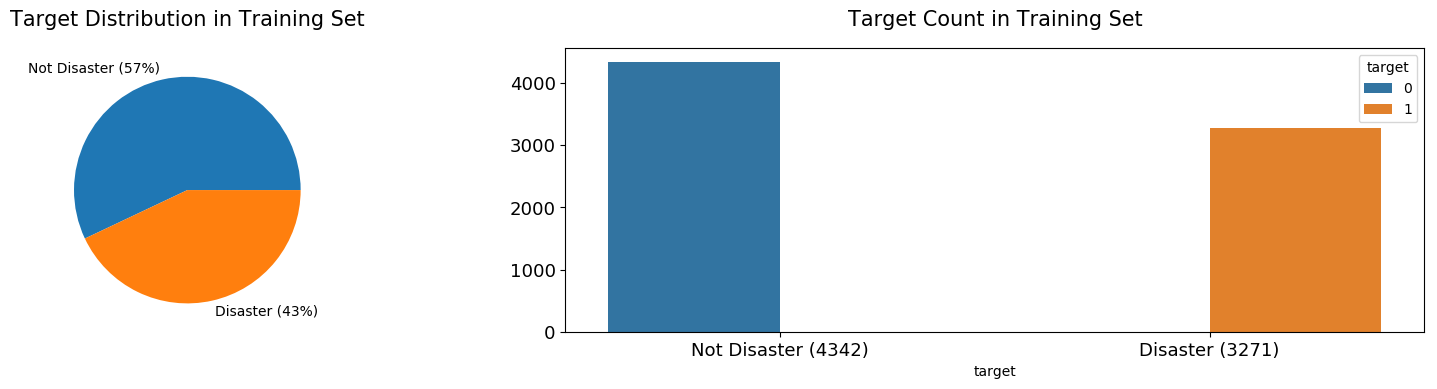

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(17, 4), dpi=100)

axes[0].pie(df_train.target.value_counts(), labels=['Not Disaster (57%)', 'Disaster (43%)'])
axes[0].set_title('Target Distribution in Training Set', size=15, y=1.05)

sns.countplot(df_train.target, hue=df_train.target, ax=axes[1])
axes[1].set_title('Target Count in Training Set', size=15, y=1.05)
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[1].set_ylabel(None)
axes[1].tick_params(axis='both', labelsize=13)

plt.tight_layout()
plt.show()

### **3.2 Unigrams**
Most common unigrams exist in **both classes** are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about `target`.

Most common unigrams in **disaster** tweets are already giving information about disasters. It is very hard to use some of those words in other contexts.

Most common unigrams in **non-disaster** tweets are verbs. This makes sense because most of those sentences have informal active structure since they are coming from individual users.

In [10]:
# Set number of ngrams to show in ngram frequency plots
plot_ngram_num = 50

# function for extracting ngram list
def generate_ngrams(text, ngram=1):
    tokens = [tok for tok in text.lower().split(' ') if tok!='' if tok not in STOPWORDS]
    ngrams = zip(*[tokens[idx:] for idx in range(ngram)])
    return [' '.join(tup) for tup in ngrams]

# function for generating ngram frequency table
def generate_ngram_freq_table(text_list, ngram=1):
    ngrams_dict = defaultdict(int)
    for tweet in text_list:
        ngram_list = generate_ngrams(tweet, ngram=ngram)
        for tmp_ngram in ngram_list:
            ngrams_dict[tmp_ngram] += 1
    return pd.DataFrame(sorted(ngrams_dict.items(), key=lambda x:x[1])[::-1])

# function for visualizing ngram frequency plots for Disaster & Non-disaster tweets
def plot_ngram_freq(df_disaster_ngrams, df_nondisaster_ngrams, ngram_name, show_ngram_num=50):
    fig, axes = plt.subplots(ncols=2, figsize=(18, plot_ngram_num/2), dpi=100)
    plt.tight_layout()
    
    sns.barplot(x=df_disaster_ngrams.loc[:plot_ngram_num, 1], y=df_disaster_ngrams.loc[:plot_ngram_num, 0],
                orient='h', ax=axes[0], color='red')
    sns.barplot(x=df_nondisaster_ngrams.loc[:plot_ngram_num, 1], y=df_nondisaster_ngrams.loc[:plot_ngram_num, 0],
                orient='h', ax=axes[1], color='green')
    
    for ax, title in zip(axes, ['Disaster', 'Non-disaster']):
        ax.spines['right'].set_visible(False)
        ax.set_title(f'Top {plot_ngram_num} most common {ngram_name}s in {title} Tweets', size=15)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.tick_params(axis='both', labelsize=13)
    
    return fig, axes

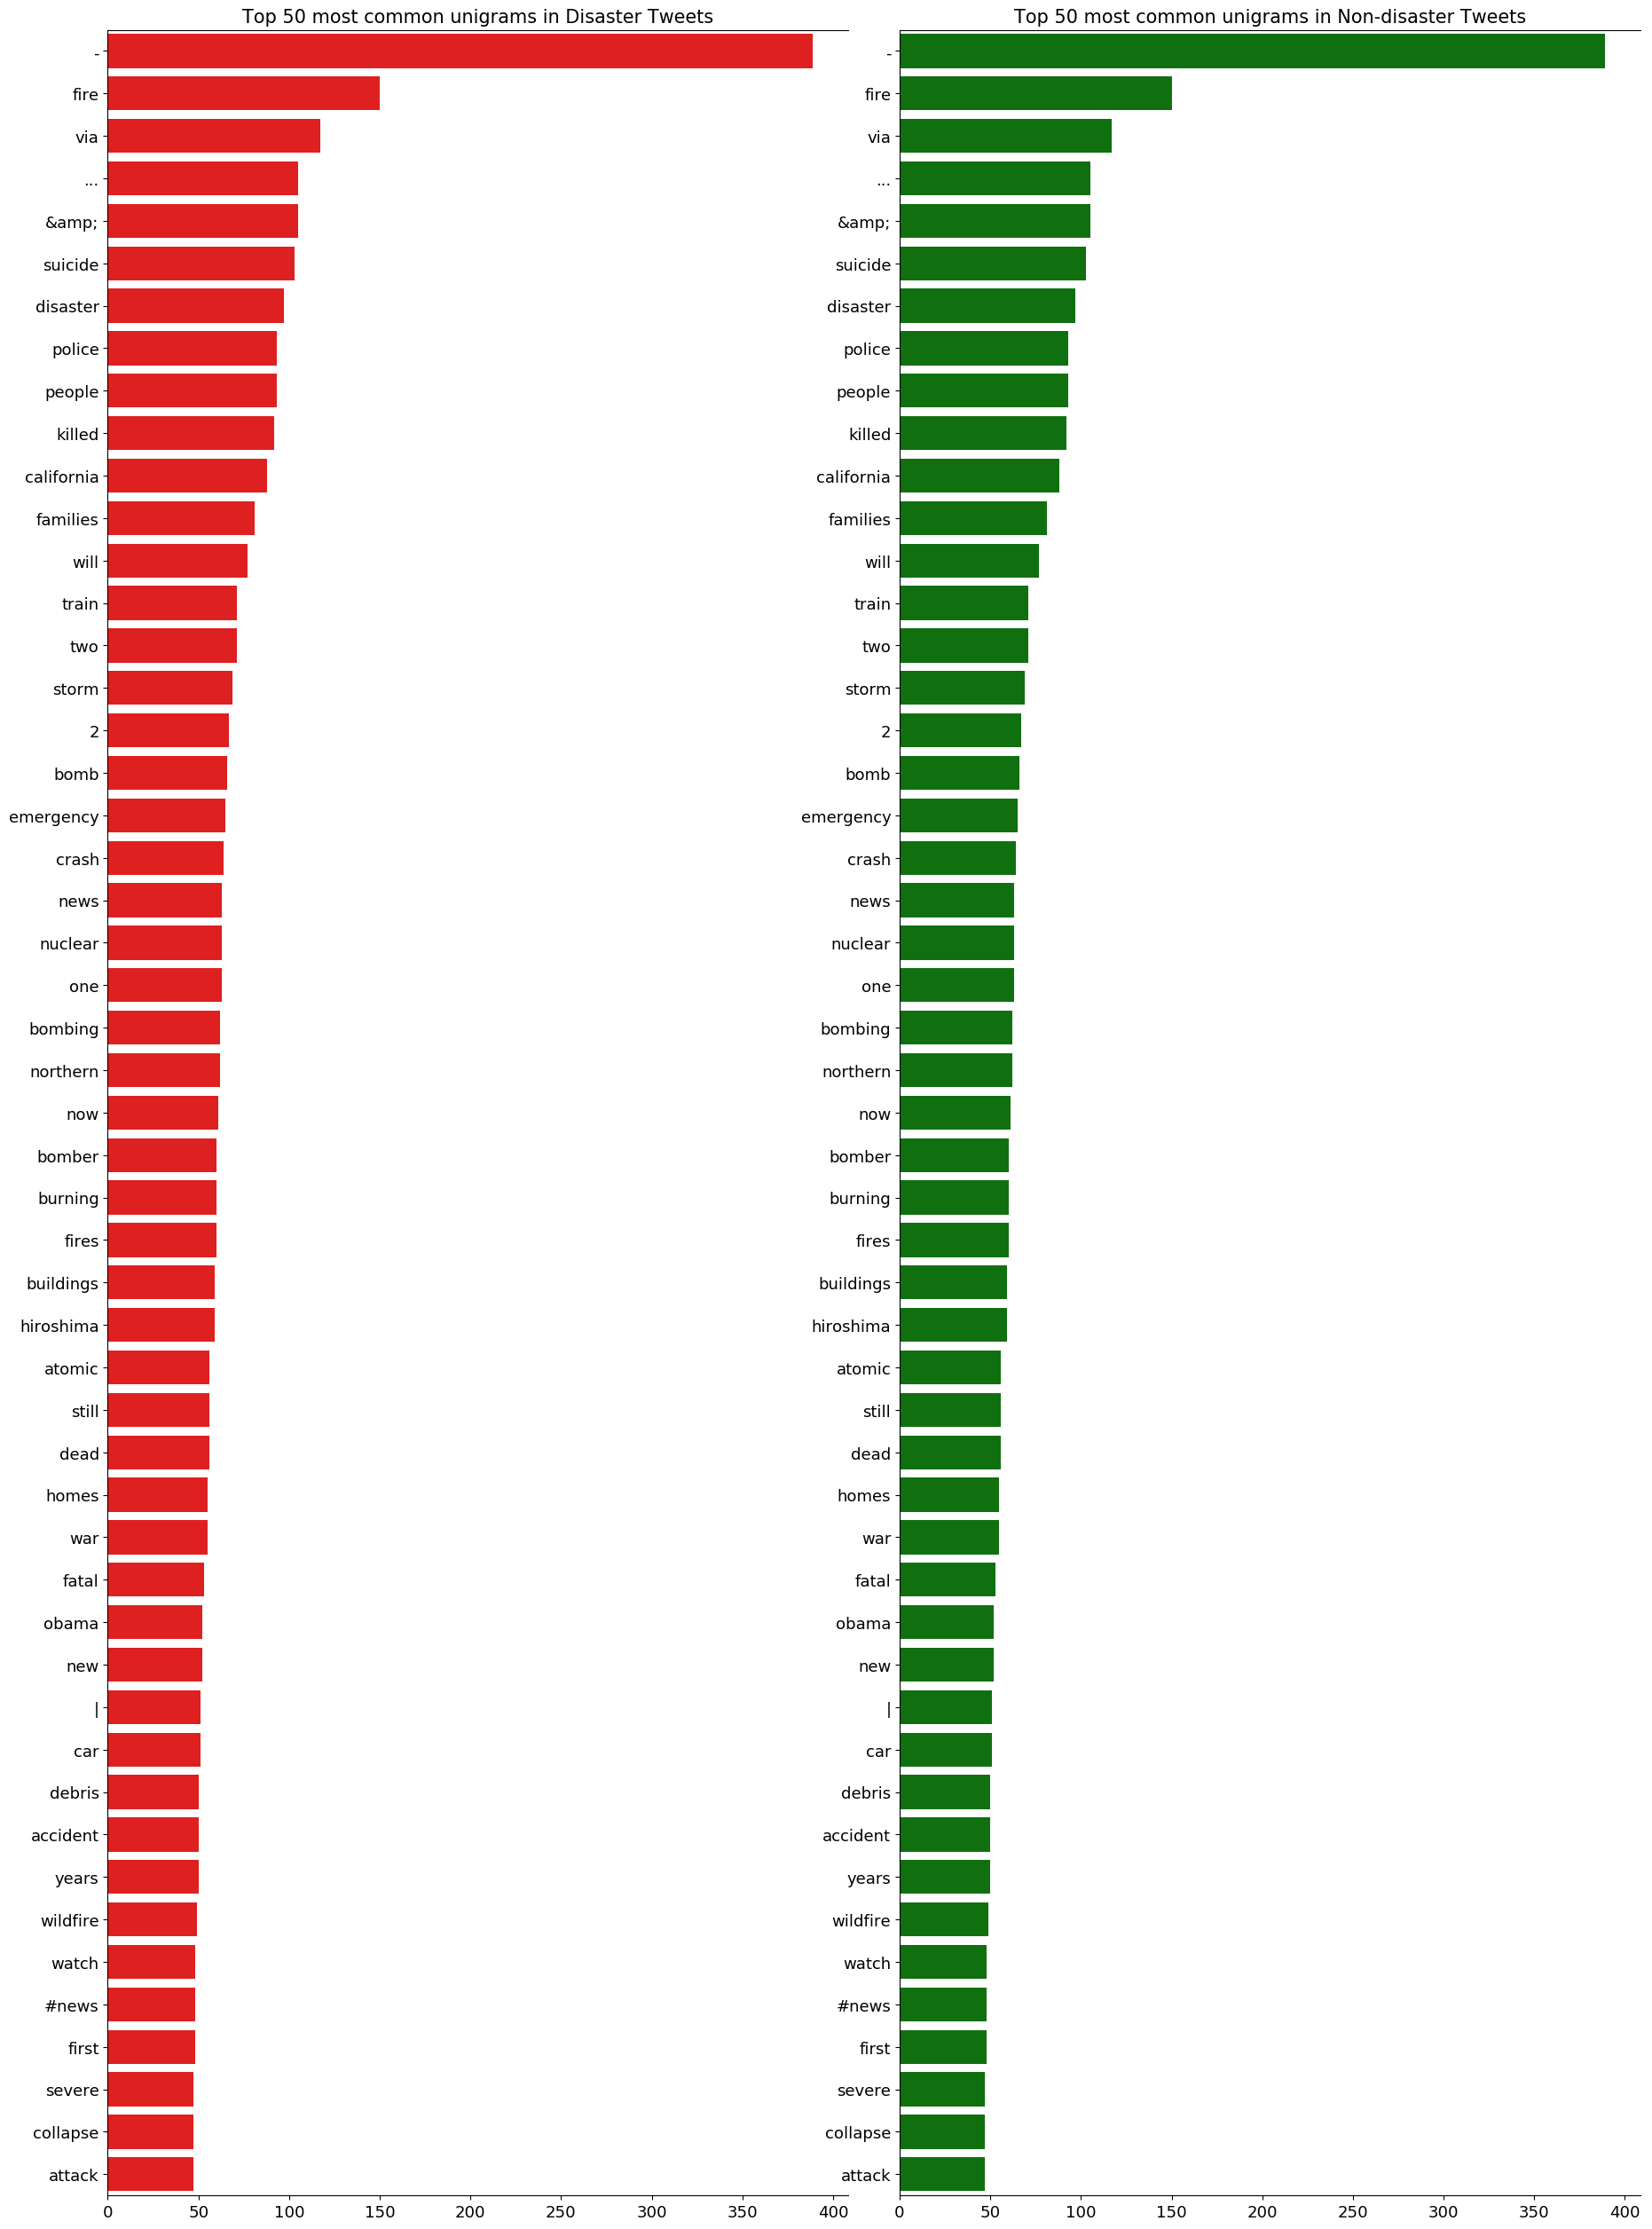

In [11]:
# Generate unigram frequency table
df_disaster_unigrams = generate_ngram_freq_table(df_train.loc[df_train.target==1, 'text'], ngram=1)
df_nondisaster_unigrams = generate_ngram_freq_table(df_train.loc[df_train.target==1, 'text'], ngram=1)

# Visualize ngram frequency plots for Disaster & Non-disaster tweets
plot_ngram_freq(df_disaster_unigrams, df_nondisaster_unigrams, ngram_name='unigram', show_ngram_num=plot_ngram_num)
plt.show()